In [16]:
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import numpy as np
import re
import os
from sklearn.metrics import brier_score_loss, log_loss

In [46]:
# Load datasets
with open("forecastbench-datasets/datasets/question_sets/2024-12-08-human.json", "r") as f:
    questions_data = json.load(f)

with open("forecastbench-datasets/datasets/resolution_sets/2024-12-08_resolution_set.json", "r") as f:
    resolutions_data = json.load(f)
resolution_dict = {}
for resolution in resolutions_data["resolutions"]:
    resolution_dict[str(resolution["id"])] = resolution

# Define models to evaluate
models = [
    "Google/gemma-3-1b-it",
    "Duruo/gemma-3-finetune-quant",
    "Duruo/gemma-3-finetune-quant-158steps"
]


In [48]:
# Count potential matches
matches = 0
for question in questions_data["questions"]:
    for resolution in resolutions_data["resolutions"]:
        if question["id"] == resolution["id"]:
            matches += 1
            break
        
print(f"Direct ID matches: {matches}/{len(questions_data['questions'])}")


Direct ID matches: 174/200


In [64]:
# Results storage
results = {model_id: [] for model_id in models}
os.makedirs("forecastbench_results", exist_ok=True)

In [65]:
from tqdm import tqdm
# Find resolved questions
example_outputs = {}
resolved_questions = []
for question in questions_data["questions"]:
    q_id = question["id"]
    if q_id in resolution_dict and resolution_dict[q_id].get("resolved", False):
        resolved_questions.append({
            "id": q_id,
            "text": question["question"],
            "background": question.get("background", ""),
            "ground_truth": resolution_dict[q_id]["resolved_to"]
        })

# Limit to 50 questions
test_questions = resolved_questions[:20]
print(f"Testing {len(test_questions)} resolved questions")

# Get raw model response for tracking example outputs
def get_model_response(model, tokenizer, question, background=""):
    prompt = f"Question: {question}\n\n Provide with ONE probability between 0 and 1: "
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=10)
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Extract probability from response
def extract_probability(response):
    match = re.search(r"(\d*\.\d+)", response)
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            return None
    return None

# Process questions with progress bar
for model_id in models:
    print(f"Testing model: {model_id}")
    
    # Load model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id, 
        torch_dtype=torch.float16,
        device_map="mps" if torch.backends.mps.is_available() else "auto"
    )
    
    # Process questions with progress bar
    for q in tqdm(test_questions, desc=f"{model_id}"):
        # Get model response
        response = get_model_response(model, tokenizer, q["text"], q["background"])
        prediction = extract_probability(response)
        
        # Save first example from each model
        if model_id not in example_outputs:
            example_outputs[model_id] = {
                "question": q["text"],
                "response": response,
                "prediction": prediction
            }
        
        # Save result
        results[model_id].append({
            "id": q["id"],
            "prediction": prediction,
            "ground_truth": q["ground_truth"]
        })
    
    # Clean up
    del model, tokenizer
    torch.mps.empty_cache() if torch.backends.mps.is_available() else None

# Show example outputs
print("\nExample outputs from each model:")
for model_id, example in example_outputs.items():
    print(f"\n{model_id}:")
    print(f"Question: {example['question'][:100]}...")
    print(f"Response: {example['response']}")
    print(f"Extracted probability: {example['prediction']}")

Testing 20 resolved questions
Testing model: Google/gemma-3-1b-it


Google/gemma-3-1b-it: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Testing model: Duruo/gemma-3-finetune-quant


Duruo/gemma-3-finetune-quant: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Testing model: Duruo/gemma-3-finetune-quant-158steps


Duruo/gemma-3-finetune-quant-158steps: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Example outputs from each model:

Google/gemma-3-1b-it:
Question: Will the "Nintendo Switch 2" (or other successor) be revealed before end of year?...
Response: Question: Will the "Nintendo Switch 2" (or other successor) be revealed before end of year?

 Provide with ONE probability between 0 and 1: 0.8.

**Answer:** 0
Extracted probability: 0.8

Duruo/gemma-3-finetune-quant:
Question: Will the "Nintendo Switch 2" (or other successor) be revealed before end of year?...
Response: Question: Will the "Nintendo Switch 2" (or other successor) be revealed before end of year?

 Provide with ONE probability between 0 and 1: 0.5.

**Answer:** 0
Extracted probability: 0.5

Duruo/gemma-3-finetune-quant-158steps:
Question: Will the "Nintendo Switch 2" (or other successor) be revealed before end of year?...
Response: Question: Will the "Nintendo Switch 2" (or other successor) be revealed before end of year?

 Provide with ONE probability between 0 and 1: 0.8, 0.2, 
Extracted probability: 0.8


Found 3 model result files
Google/gemma-3-1b-it: 10 valid predictions
Duruo/gemma-3-finetune-quant: 11 valid predictions
Duruo/gemma-3-finetune-quant-158steps: 11 valid predictions

Evaluation Results:
Google/gemma-3-1b-it:
  - Valid predictions: 10
  - Brier score: 0.2541
  - Cross entropy: 4.0581
  - Mean prediction: 0.5040
Duruo/gemma-3-finetune-quant:
  - Valid predictions: 11
  - Brier score: 0.3870
  - Cross entropy: 10.1784
  - Mean prediction: 0.4736
Duruo/gemma-3-finetune-quant-158steps:
  - Valid predictions: 11
  - Brier score: 0.3537
  - Cross entropy: 7.0429
  - Mean prediction: 0.5764
Saved plot to forecastbench_results/model_comparison.png


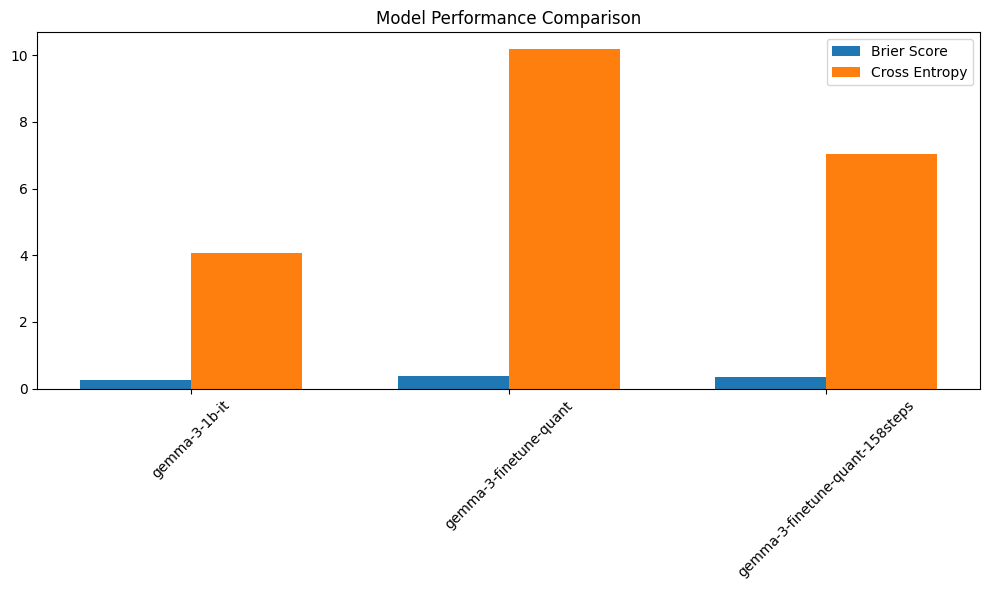

In [66]:
import json
import re
import os
import numpy as np
from sklearn.metrics import brier_score_loss, log_loss
import matplotlib.pyplot as plt

# Function to extract probability from text response
def extract_probability(text):
    if not isinstance(text, str):
        return None
        
    # Look for percentage
    percentage_match = re.search(r'(\d+)%', text)
    if percentage_match:
        try:
            return float(percentage_match.group(1)) / 100
        except:
            pass
    
    # Look for decimal number
    decimal_match = re.search(r'(\d*\.\d+)', text)
    if decimal_match:
        try:
            return float(decimal_match.group(1))
        except:
            pass
            
    # Look for whole number probability
    if '0.1' in text or '0.2' in text or '0.3' in text:
        whole_match = re.search(r'0\.(\d+)', text)
        if whole_match:
            try:
                return float('0.' + whole_match.group(1))
            except:
                pass
                
    return None

# Process all JSON files in the results directory
results_dir = "forecastbench_results"
metrics = {}

model_files = [f for f in os.listdir(results_dir) if f.endswith('.json')]
print(f"Found {len(model_files)} model result files")

for model_file in model_files:
    model_id = model_file.replace('.json', '').replace('_', '/')
    
    # Load predictions
    with open(os.path.join(results_dir, model_file), 'r') as f:
        predictions = json.load(f)
    
    # Extract numerical predictions
    valid_pairs = []
    for p in predictions:
        if isinstance(p["prediction"], str):
            extracted = extract_probability(p["prediction"])
            if extracted is not None:
                valid_pairs.append((extracted, p["ground_truth"]))
        elif isinstance(p["prediction"], (int, float)):
            valid_pairs.append((p["prediction"], p["ground_truth"]))
    
    if valid_pairs:
        y_pred = [p for p, _ in valid_pairs]
        y_true = [t for _, t in valid_pairs]
        
        metrics[model_id] = {
            "count": len(valid_pairs),
            "brier_score": float(brier_score_loss(y_true, y_pred)),
            "cross_entropy": float(log_loss(y_true, y_pred)),
            "mean_prediction": float(np.mean(y_pred))
        }
        
        print(f"{model_id}: {len(valid_pairs)} valid predictions")

# Print results
print("\nEvaluation Results:")
for model_id, stats in metrics.items():
    print(f"{model_id}:")
    print(f"  - Valid predictions: {stats['count']}")
    print(f"  - Brier score: {stats['brier_score']:.4f}")
    print(f"  - Cross entropy: {stats['cross_entropy']:.4f}")
    print(f"  - Mean prediction: {stats['mean_prediction']:.4f}")

# Save metrics
with open(os.path.join(results_dir, "evaluation_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Plot comparison
plt.figure(figsize=(10, 6))
models = list(metrics.keys())
brier_scores = [metrics[m]["brier_score"] for m in models]
cross_entropy = [metrics[m]["cross_entropy"] for m in models]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, brier_scores, width, label='Brier Score')
plt.bar(x + width/2, cross_entropy, width, label='Cross Entropy')
plt.xticks(x, [m.split('/')[-1] for m in models], rotation=45)
plt.legend()
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "model_comparison.png"))
print(f"Saved plot to {os.path.join(results_dir, 'model_comparison.png')}")